In [1]:
# Essential imports:
import pandas as pd
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('fivethirtyeight')

%matplotlib inline

# Modeling imports:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.model_selection import train_test_split, KFold, cross_val_score, GridSearchCV, cross_validate
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, roc_auc_score, roc_curve, precision_recall_curve
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from xgboost import XGBClassifier

In [2]:
# Importing the dataset

df = pd.read_csv('hotel_booking.csv')

## EDA:

In [3]:
# Removing unnecessary columns

df.drop(columns=['credit_card', 'phone-number', 'email',
                 'name', 'reservation_status_date', 'reservation_status',
                 'assigned_room_type', 'agent', 'company', 'arrival_date_year',
                 'arrival_date_week_number', 'country'], inplace=True)

In [4]:
df.describe()

,is_canceled,lead_time,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,booking_changes,days_in_waiting_list,adr,required_car_parking_spaces,total_of_special_requests
count,119390.000000,119390.000000,119390.000000,119390.000000,119390.000000,119390.000000,119386.000000,119390.000000,119390.000000,119390.000000,119390.000000,119390.000000,119390.000000,119390.000000,119390.000000,119390.000000
mean,0.370416,104.011416,15.798241,0.927599,2.500302,1.856403,0.103890,0.007949,0.031912,0.087118,0.137097,0.221124,2.321149,101.831122,0.062518,0.571363
std,0.482918,106.863097,8.780829,0.998613,1.908286,0.579261,0.398561,0.097436,0.175767,0.844336,1.497437,0.652306,17.594721,50.535790,0.245291,0.792798
min,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-6.380000,0.000000,0.000000
25%,0.000000,18.000000,8.000000,0.000000,1.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,69.290000,0.000000,0.000000
50%,0.000000,69.000000,16.000000,1.000000,2.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,94.575000,0.000000,0.000000
75%,1.000000,160.000000,23.000000,2.000000,3.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,126.000000,0.000000,1.000000
max,1.000000,737.000000,31.000000,19.000000,50.000000,55.000000,10.000000,10.000000,1.000000,26.000000,72.000000,21.000000,391.000000,5400.000000,8.000000,5.000000


### Average Daily Rate data seems a bit out of range. So outliers will be removed for that variable:

In [5]:
# Removal of out of average daily rate outliers

df.drop(df[df['adr']<10].index, inplace=True)
df.drop(df[df['adr']>210].index, inplace=True)
df.reset_index(inplace=True)
df.drop(columns=['index'], inplace=True)

### The target classes breakdown:

<AxesSubplot:>

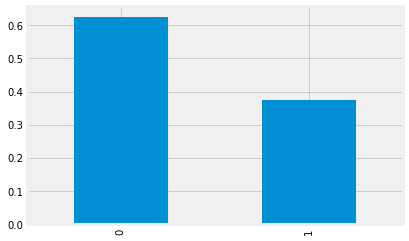

In [6]:
target_pcts = df['is_canceled'].value_counts(normalize=True)
target_pcts.plot(kind='bar')

### Visualization of a handful of original categorical features: 

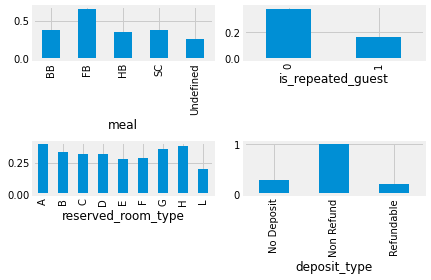

In [7]:
plt.figure()
plt.subplot(2,2,1)
df.groupby(['meal']).is_canceled.mean().plot(kind='bar')
plt.subplot(2,2,2)
df.groupby(['is_repeated_guest']).is_canceled.mean().plot(kind='bar')
plt.subplot(2,2,3)
df.groupby(['reserved_room_type']).is_canceled.mean().plot(kind='bar')
plt.subplot(2,2,4)
df.groupby(['deposit_type']).is_canceled.mean().plot(kind='bar')

plt.tight_layout()

(0.0, 650.0)

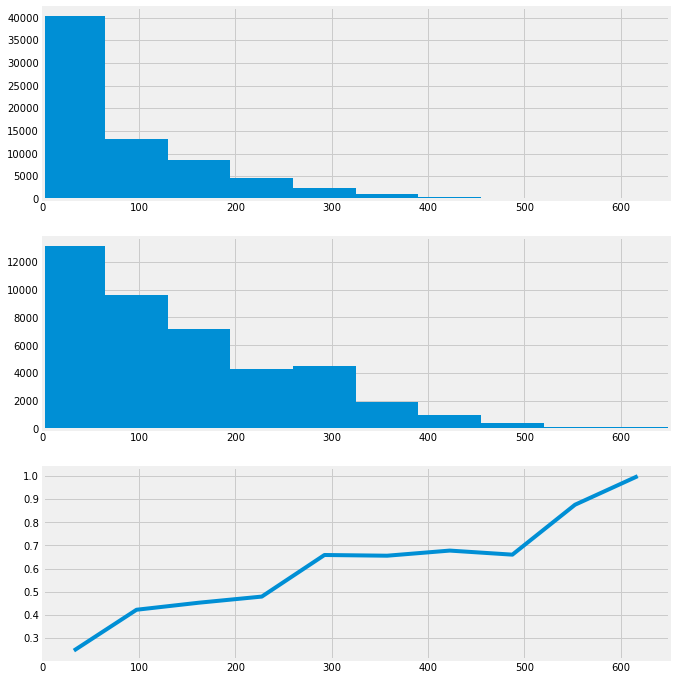

In [8]:
fig, ax = plt.subplots(3, 1, figsize=(10, 12))

count0, bins_0, _ = ax[0].hist(df.loc[(df['is_canceled']==0),'lead_time'], bins=10, range=(0,650))
count1, bins_1, _ = ax[1].hist(df.loc[(df['is_canceled']==1),'lead_time'], bins=10, range=(0,650))
ax[2].plot((bins_0[:-1]+bins_0[1:])/2,count1/(count1 + count0));
ax[0].set_xlim([0, 650])
ax[1].set_xlim([0, 650])
ax[2].set_xlim([0, 650])

<ipython-input-9-95b7513b9973>:5: RuntimeWarning: invalid value encountered in true_divide
  ax[2].plot((bins_0[:-1]+bins_0[1:])/2,count1/(count1 + count0));


(0.0, 250.0)

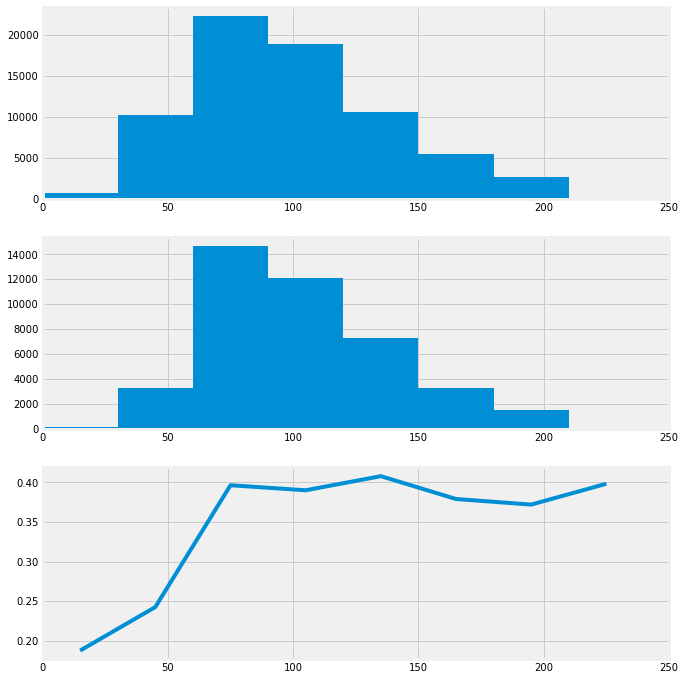

In [9]:
fig, ax = plt.subplots(3, 1, figsize=(10, 12))

count0, bins_0, _ = ax[0].hist(df.loc[(df['is_canceled']==0),'adr'], bins=10, range=(0,300))
count1, bins_1, _ = ax[1].hist(df.loc[(df['is_canceled']==1),'adr'], bins=10, range=(0,300))
ax[2].plot((bins_0[:-1]+bins_0[1:])/2,count1/(count1 + count0));
ax[0].set_xlim([0, 250])
ax[1].set_xlim([0, 250])
ax[2].set_xlim([0, 250])

### Based on these and other (not shown) plots, a few features would be engineered: 

In [10]:
# Total number of children

df['children'] = df['children'] + df['babies']

In [11]:
# If the arrival time is in a holiday season or not

holiday_season = []
for index, month in enumerate(df['arrival_date_month']):
    
    if month == 'April':
        if df['arrival_date_day_of_month'][index] in range(6):
            holiday_season.append(1)
        else:
            holiday_season.append(0)
    elif month == 'December':
        if df['arrival_date_day_of_month'][index] in range(20, 32):
            holiday_season.append(1)
        else:
            holiday_season.append(0)
    elif month == 'January':
        if df['arrival_date_day_of_month'][index] in range(6):
            holiday_season.append(1)
        else:
            holiday_season.append(0)
    else:
        holiday_season.append(0)  

        
df['holiday_season'] = holiday_season

In [12]:
# If the arrival time is in a summer season or not


summer_season = []
for index, month in enumerate(df['arrival_date_month']):
    if month in ['June', 'July', 'August']:
        summer_season.append(1)
    else:
        summer_season.append(0)


df['summer_season'] = summer_season

In [13]:
# Total stay (nights)

df['total_nights'] = df['stays_in_weekend_nights'] + df['stays_in_week_nights']
df.drop(df[df['total_nights']<=0].index, inplace=True)
df.reset_index(inplace=True)
df.drop(columns=['index'], inplace=True)

In [14]:
# This feature is defined as an index, having direct relationship with lead time and inverse relationship with total cost

scaled_lead_time = (df['lead_time'] - min(df['lead_time']))/(max(df['lead_time']) - min(df['lead_time']))
scaled_adr = (df['adr'] - min(df['adr']))/(max(df['adr']) - min(df['adr']))

df['new_index'] = scaled_lead_time*scaled_adr

In [15]:
# If the stay involves weekend days

weekend_stay = []
for i in df['stays_in_weekend_nights']:
    
    if i != 0:
        weekend_stay.append(1)
        
    else:
        weekend_stay.append(0)
        

df['weekend_stay'] = weekend_stay

In [16]:
# Total number of gusts

df['total_guests'] = df['adults'] + df['children']
df.drop(df[df['total_guests']<=0].index, inplace=True)
df.reset_index(inplace=True)
df.drop(columns=['index'], inplace=True)

In [17]:
# If the booking invloves children

have_children = []

for i in df['children']:
    
    if i != 0:
        have_children.append(1)
        
    else:
        have_children.append(0)
        

df['have_children'] = have_children

In [18]:
# If customer cancelled any reservation before

have_prev_cancellations = []
for i in df['previous_cancellations']:
    
    if i != 0:
        have_prev_cancellations.append(1)
        
    else:
        have_prev_cancellations.append(0)
        

df['have_prev_cancellations'] = have_prev_cancellations

In [19]:
# If the booking has been changed

have_booking_change = []
for i in df['booking_changes']:
    
    if i != 0:
        have_booking_change.append(1)
        
    else:
        have_booking_change.append(0)
        

df['have_booking_change'] = have_booking_change

In [20]:
# If the customer asked for parking 

have_required_parking = []
for i in df['required_car_parking_spaces']:
    
    if i != 0:
        have_required_parking.append(1)
        
    else:
        have_required_parking.append(0)
        

df['have_required_parking'] = have_required_parking

In [21]:
# If the customer had a special request

have_special_requests = []
for i in df['total_of_special_requests']:
    
    if i != 0:
        have_special_requests.append(1)
        
    else:
        have_special_requests.append(0)
        

df['have_special_requests'] = have_special_requests

### Visualization of a handful of the engineered categorical features: 

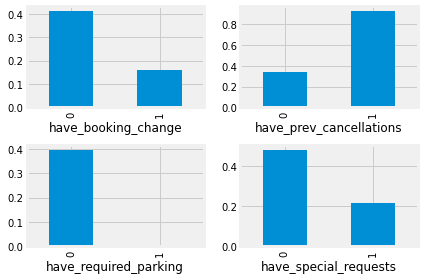

In [22]:
plt.figure()
plt.subplot(2,2,1)
df.groupby(['have_booking_change']).is_canceled.mean().plot(kind='bar')
plt.subplot(2,2,2)
df.groupby(['have_prev_cancellations']).is_canceled.mean().plot(kind='bar')
plt.subplot(2,2,3)
df.groupby(['have_required_parking']).is_canceled.mean().plot(kind='bar')
plt.subplot(2,2,4)
df.groupby(['have_special_requests']).is_canceled.mean().plot(kind='bar')

plt.tight_layout()

<ipython-input-23-4fafd0a4da3b>:5: RuntimeWarning: invalid value encountered in true_divide
  ax[2].plot((bins_0[:-1]+bins_0[1:])/2,count1/(count1 + count0));


(0.0, 10.0)

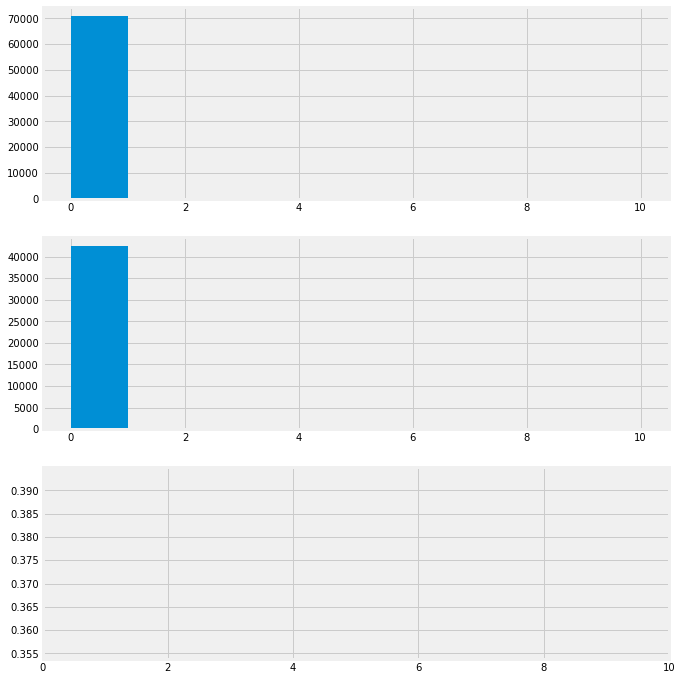

In [23]:
fig, ax = plt.subplots(3, 1, figsize=(10, 12))

count0, bins_0, _ = ax[0].hist(df.loc[(df['is_canceled']==0),'new_index'], bins=10, range=(0,10))
count1, bins_1, _ = ax[1].hist(df.loc[(df['is_canceled']==1),'new_index'], bins=10, range=(0,10))
ax[2].plot((bins_0[:-1]+bins_0[1:])/2,count1/(count1 + count0));
ax[2].set_xlim([0, 10])

(0.0, 50.0)

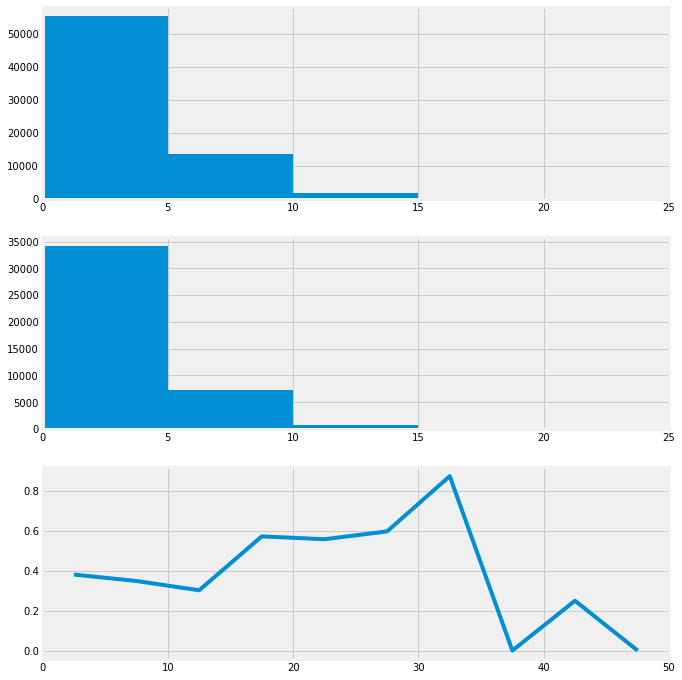

In [24]:
fig, ax = plt.subplots(3, 1, figsize=(10, 12))

count0, bins_0, _ = ax[0].hist(df.loc[(df['is_canceled']==0),'total_nights'], bins=10, range=(0,50))
count1, bins_1, _ = ax[1].hist(df.loc[(df['is_canceled']==1),'total_nights'], bins=10, range=(0,50))
ax[2].plot((bins_0[:-1]+bins_0[1:])/2,count1/(count1 + count0));
ax[0].set_xlim([0, 25])
ax[1].set_xlim([0, 25])
ax[2].set_xlim([0, 50])

### Introduction of the dummy variables for non-binary or non-numeric categorical data:

In [25]:
# Creating the dummies

dummies = pd.get_dummies(df[['meal', 'distribution_channel',
                             'reserved_room_type', 'deposit_type']])

# 'market_segment', 'customer_type'

In [26]:
# Removal of unneccesary original columns

df.drop(columns=['arrival_date_day_of_month','arrival_date_month',
                 'meal', 'market_segment',
                 'distribution_channel', 'reserved_room_type', 'deposit_type',
                 'customer_type', 'adults', 'children',
                 'previous_cancellations', 'previous_bookings_not_canceled',
                 'booking_changes', 'required_car_parking_spaces', 'total_of_special_requests',
                 'stays_in_weekend_nights', 'stays_in_week_nights', 'babies'], inplace=True)

#  'adults', 'children',
#                  'previous_cancellations', 'previous_bookings_not_canceled',
#                  'booking_changes', 'required_car_parking_spaces', 'total_of_special_requests',
#                  'stays_in_weekend_nights', 'stays_in_week_nights'

In [27]:
# Adding the dummies to the original df

df_with_dummies = pd.concat([df, dummies], axis=1)

In [28]:
# Finding the null values

df_with_dummies.isnull().sum().sum()

4

In [29]:
# Removing the null values

df_with_dummies.fillna(0, inplace=True)

In [30]:
# df_with_dummies = df_with_dummies[['is_canceled', 'deposit_type_Non Refund', 'deposit_type_No Deposit',
# 'lead_time', 'have_special_requests',
# 'have_prev_cancellations', 'new', 'have_booking_change',
# 'adr', 'have_required_parking']]

In [31]:
df_with_dummies.head()

,hotel,is_canceled,lead_time,is_repeated_guest,days_in_waiting_list,adr,holiday_season,summer_season,total_nights,new_index,...,reserved_room_type_C,reserved_room_type_D,reserved_room_type_E,reserved_room_type_F,reserved_room_type_G,reserved_room_type_H,reserved_room_type_L,deposit_type_No Deposit,deposit_type_Non Refund,deposit_type_Refundable
0,Resort Hotel,0,7,0,0,75.0,0,1,1,0.003209,...,0,0,0,0,0,0,0,1,0,0
1,Resort Hotel,0,13,0,0,75.0,0,1,1,0.005959,...,0,0,0,0,0,0,0,1,0,0
2,Resort Hotel,0,14,0,0,98.0,0,1,2,0.008688,...,0,0,0,0,0,0,0,1,0,0
3,Resort Hotel,0,14,0,0,98.0,0,1,2,0.008688,...,0,0,0,0,0,0,0,1,0,0
4,Resort Hotel,0,0,0,0,107.0,0,1,2,0.000000,...,1,0,0,0,0,0,0,1,0,0


## Modeling Pre-Processing:

In [32]:
# Creating the hold-out (test set)

X, X_test, y, y_test = train_test_split(df_with_dummies.iloc[:, 2:],
                                                    df_with_dummies['is_canceled'], 
                                                    test_size=0.2, 
                                                    random_state=42)

In [33]:
# Dividing the remaining data into train and validation sets

X_train, X_val, y_train, y_val = train_test_split(X.iloc[:, 0:],
                                                    y, 
                                                    test_size=0.25, 
                                                    random_state=42) 

In [34]:
# Scaling the data for modeling purposes

scaler = MinMaxScaler()
scaled_train = scaler.fit_transform(X_train)
train_set_scaled = X_train.copy()
train_set_scaled[['lead_time', 'is_repeated_guest', 'days_in_waiting_list', 'adr',
       'holiday_season', 'summer_season', 'total_nights', 'new',
       'weekend_stay', 'total_guests', 'have_children',
       'have_prev_cancellations', 'have_booking_change',
       'have_required_parking', 'have_special_requests', 'meal_BB', 'meal_FB',
       'meal_HB', 'meal_SC', 'meal_Undefined',
       'distribution_channel_Corporate', 'distribution_channel_Direct',
       'distribution_channel_GDS', 'distribution_channel_TA/TO',
       'distribution_channel_Undefined', 'reserved_room_type_A',
       'reserved_room_type_B', 'reserved_room_type_C', 'reserved_room_type_D',
       'reserved_room_type_E', 'reserved_room_type_F', 'reserved_room_type_G',
       'reserved_room_type_H', 'reserved_room_type_L',
       'deposit_type_No Deposit', 'deposit_type_Non Refund',
       'deposit_type_Refundable']] = scaled_train


scaled_val = scaler.fit_transform(X_val)
val_set_scaled = X_val.copy()
val_set_scaled[['lead_time', 'is_repeated_guest', 'days_in_waiting_list', 'adr',
       'holiday_season', 'summer_season', 'total_nights', 'new',
       'weekend_stay', 'total_guests', 'have_children',
       'have_prev_cancellations', 'have_booking_change',
       'have_required_parking', 'have_special_requests', 'meal_BB', 'meal_FB',
       'meal_HB', 'meal_SC', 'meal_Undefined',
       'distribution_channel_Corporate', 'distribution_channel_Direct',
       'distribution_channel_GDS', 'distribution_channel_TA/TO',
       'distribution_channel_Undefined', 'reserved_room_type_A',
       'reserved_room_type_B', 'reserved_room_type_C', 'reserved_room_type_D',
       'reserved_room_type_E', 'reserved_room_type_F', 'reserved_room_type_G',
       'reserved_room_type_H', 'reserved_room_type_L',
       'deposit_type_No Deposit', 'deposit_type_Non Refund',
       'deposit_type_Refundable']] = scaled_val

In [35]:
# Defining the cross-validation splitter function

kf = KFold(n_splits=5, shuffle=True, random_state = 42)

## Modeling 

### Each of the following models are being fitted to the entire training data. For diagnostic purposes, the average for each metric would be calculated across 5 cross validation groups:

In [36]:
# K Nearest Neighbors

knn = KNeighborsClassifier() 
knn.fit(train_set_scaled, y_train)

knn_scores = cross_validate(knn, train_set_scaled, y_train, cv=kf, scoring=['accuracy', 'precision',
                                                                           'recall', 'f1', 'roc_auc'])

knn_accuracy, knn_preciscion, knn_recall, knn_f1, knn_auc = (knn_scores['test_accuracy'],
                                                                                 knn_scores['test_precision'],
                                                                                 knn_scores['test_recall'],
                                                                                 knn_scores['test_f1'],
                                                                                 knn_scores['test_roc_auc'])

print(f'KNN CV Accuracy: {np.mean(knn_accuracy):.3f} +- {np.std(knn_accuracy):.3f}')
print(f'KNN CV Precision: {np.mean(knn_preciscion):.3f} +- {np.std(knn_preciscion):.3f}')
print(f'KNN CV Recall: {np.mean(knn_recall):.3f} +- {np.std(knn_recall):.3f}')
print(f'KNN CV F1: {np.mean(knn_f1):.3f} +- {np.std(knn_f1):.3f}')
print(f'KNN CV AUC: {np.mean(knn_auc):.3f} +- {np.std(knn_auc):.3f}')

KNN CV Accuracy: 0.806 +- 0.003
KNN CV Precision: 0.775 +- 0.006
KNN CV Recall: 0.676 +- 0.010
KNN CV F1: 0.722 +- 0.006
KNN CV AUC: 0.854 +- 0.001


In [37]:
# Logistic Regression

log_reg = LogisticRegression(max_iter=2000) 
log_reg.fit(train_set_scaled, y_train)

log_reg_scores = cross_validate(log_reg, train_set_scaled, y_train, cv=kf, scoring=['accuracy', 'precision',
                                                                           'recall', 'f1', 'roc_auc'])

log_reg_accuracy, log_reg_preciscion, log_reg_recall, log_reg_f1, log_reg_auc = (log_reg_scores['test_accuracy'],
                                                                                 log_reg_scores['test_precision'],
                                                                                 log_reg_scores['test_recall'],
                                                                                 log_reg_scores['test_f1'],
                                                                                 log_reg_scores['test_roc_auc'])

print(f'Logistic Regression CV Accuracy: {np.mean(log_reg_accuracy):.3f} +- {np.std(log_reg_accuracy):.3f}')
print(f'Logistic Regression CV Precision: {np.mean(log_reg_preciscion):.3f} +- {np.std(log_reg_preciscion):.3f}')
print(f'Logistic Regression CV Recall: {np.mean(log_reg_recall):.3f} +- {np.std(log_reg_recall):.3f}')
print(f'Logistic Regression CV F1: {np.mean(log_reg_f1):.3f} +- {np.std(log_reg_f1):.3f}')
print(f'Logistic Regression CV AUC: {np.mean(log_reg_auc):.3f} +- {np.std(log_reg_auc):.3f}')

Logistic Regression CV Accuracy: 0.791 +- 0.002
Logistic Regression CV Precision: 0.862 +- 0.005
Logistic Regression CV Recall: 0.525 +- 0.005
Logistic Regression CV F1: 0.652 +- 0.005
Logistic Regression CV AUC: 0.833 +- 0.001


In [38]:
# Decision Tree Classifier 

dt = DecisionTreeClassifier()
dt.fit(train_set_scaled, y_train)

dt_scores = cross_validate(dt, train_set_scaled, y_train, cv=kf, scoring=['accuracy', 'precision',
                                                                 'recall', 'f1', 'roc_auc'])
dt_accuracy, dt_preciscion, dt_recall, dt_f1, dt_auc = (dt_scores['test_accuracy'],
                                                dt_scores['test_precision'],
                                                dt_scores['test_recall'],
                                                dt_scores['test_f1'],
                                                dt_scores['test_roc_auc'])

print(f'Decision Tree CV Accuracy: {np.mean(dt_accuracy):.3f} +- {np.std(dt_accuracy):.3f}')
print(f'Decision Tree CV Precision: {np.mean(dt_preciscion):.3f} +- {np.std(dt_preciscion):.3f}')
print(f'Decision Tree CV Recall: {np.mean(dt_recall):.3f} +- {np.std(dt_recall):.3f}')
print(f'Decision Tree CV F1: {np.mean(dt_f1):.3f} +- {np.std(dt_f1):.3f}')
print(f'Decision Tree CV AUC: {np.mean(dt_auc):.3f} +- {np.std(dt_auc):.3f}')

Decision Tree CV Accuracy: 0.793 +- 0.004
Decision Tree CV Precision: 0.722 +- 0.002
Decision Tree CV Recall: 0.725 +- 0.010
Decision Tree CV F1: 0.723 +- 0.005
Decision Tree CV AUC: 0.782 +- 0.004


In [39]:
# Random Forest Classifier

rf = RandomForestClassifier()
rf.fit(train_set_scaled, y_train)

rf_scores = cross_validate(rf, train_set_scaled, y_train, cv=kf, scoring=['accuracy', 'precision',
                                                                 'recall', 'f1', 'roc_auc'])
rf_accuracy, rf_precision, rf_recall, rf_f1, rf_acu = (rf_scores['test_accuracy'],
                                                       rf_scores['test_precision'],
                                                       rf_scores['test_recall'],
                                                       rf_scores['test_f1'],
                                                       rf_scores['test_roc_auc'])

print(f'Random Forest CV Accuracy: {np.mean(rf_accuracy):.3f} +- {np.std(rf_accuracy):.3f}')
print(f'Random Forest CV Precision: {np.mean(rf_precision):.3f} +- {np.std(rf_precision):.3f}')
print(f'Random Forest CV Recall: {np.mean(rf_recall):.3f} +- {np.std(rf_recall):.3f}')
print(f'Random Forest CV F1: {np.mean(rf_f1):.3f} +- {np.std(rf_f1):.3f}')
print(f'Random Forest CV AUC: {np.mean(rf_acu):.3f} +- {np.std(rf_acu):.3f}')

Random Forest CV Accuracy: 0.835 +- 0.003
Random Forest CV Precision: 0.834 +- 0.004
Random Forest CV Recall: 0.698 +- 0.008
Random Forest CV F1: 0.760 +- 0.004
Random Forest CV AUC: 0.900 +- 0.001


In [40]:
# XGBoost Classifier

xgbc = XGBClassifier(use_label_encoder=False, n_estimators=100,
                       max_depth=25,
                       objective="reg:squarederror",  
                       learning_rate=.1, 
                       subsample=1,
                       min_child_weight=1,
                       colsample_bytree=.8)
xgbc.fit(train_set_scaled, y_train)

xgbc_scores = cross_validate(xgbc, train_set_scaled, y_train, cv=kf, scoring=['accuracy', 'precision',
                                                                 'recall', 'f1', 'roc_auc'])
xgbc_accuracy, xgbc_precision, xgbc_recall, xgbc_f1, xgbc_acu = (xgbc_scores['test_accuracy'],
                                                       xgbc_scores['test_precision'],
                                                       xgbc_scores['test_recall'],
                                                       xgbc_scores['test_f1'],
                                                       xgbc_scores['test_roc_auc'])

print(f'XGBoost CV Accuracy: {np.mean(xgbc_accuracy):.3f} +- {np.std(xgbc_accuracy):.3f}')
print(f'XGBoost CV Precision: {np.mean(xgbc_precision):.3f} +- {np.std(xgbc_precision):.3f}')
print(f'XGBoost CV Recall: {np.mean(xgbc_recall):.3f} +- {np.std(xgbc_recall):.3f}')
print(f'XGBoost CV F1: {np.mean(xgbc_f1):.3f} +- {np.std(xgbc_f1):.3f}')
print(f'XGBoost CV AUC: {np.mean(xgbc_acu):.3f} +- {np.std(xgbc_acu):.3f}')

XGBoost CV Accuracy: 0.830 +- 0.003
XGBoost CV Precision: 0.810 +- 0.004
XGBoost CV Recall: 0.713 +- 0.007
XGBoost CV F1: 0.758 +- 0.002
XGBoost CV AUC: 0.894 +- 0.001


### An ensemble model will also be fitted to the data and the performance will be tested: 

In [41]:
# Individual AUC socres

model_names = ['log_reg', 'knn', 'rf', 'dt', 'xgbc']

for model_name in model_names:
    curr_model = eval(model_name)
    print(f'{model_name} score: {roc_auc_score(y_val, curr_model.predict_proba(val_set_scaled)[:,1])}')

log_reg score: 0.8333480952916041
knn score: 0.8477459622905651
rf score: 0.8887672057289441
dt score: 0.7414878924084711
xgbc score: 0.8733969992291175


In [42]:
# Setting up the variables for the Vorting Classifier

model_vars = [eval(n) for n in model_names]
model_list = list(zip(model_names, model_vars))

In [43]:
# Fitting the Voting Classifier and scoring the validation set

voting_classifer = VotingClassifier(estimators=model_list,
                                    voting='soft', 
                                    n_jobs=-1)
voting_classifer.fit(train_set_scaled, y_train)

roc_auc_score(y_val, voting_classifer.predict_proba(val_set_scaled)[:,1])

0.8799127720746255

### The ROC_AUC score from the Voting classifier is roughly the same as the score from the best model , Random Forest. therefore it will be dropped for the sake of training time and simplicity.

### Now the final model will be selected. For this purpose, the ROC for the 5 existing models will be used: 

<Figure size 720x720 with 0 Axes>

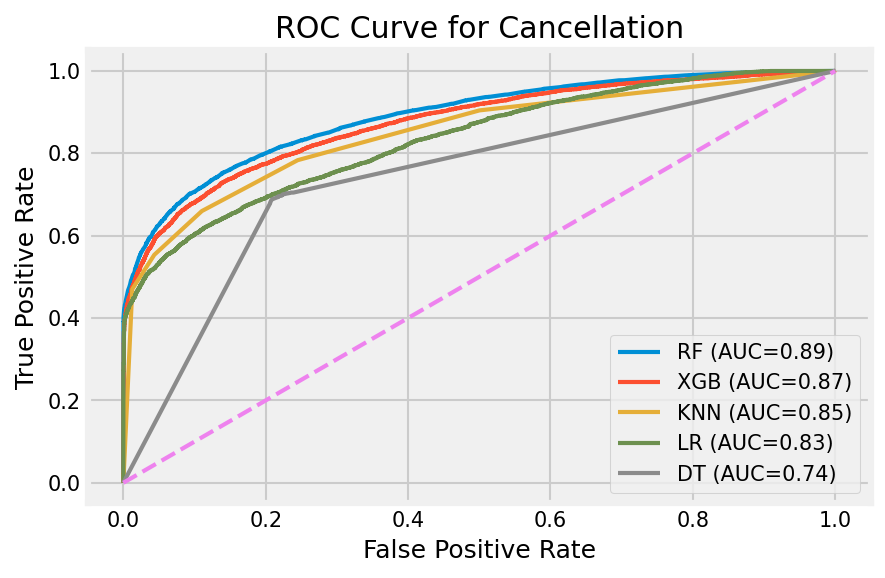

In [44]:
# ROC curve for all 5 models

plt.figure(figsize=(10, 10))
plt.figure(dpi=150)
fpr1, tpr1, thresholds1 = roc_curve(y_val, rf.predict_proba(val_set_scaled)[:,1])
fpr2, tpr2, thresholds2 = roc_curve(y_val, xgbc.predict_proba(val_set_scaled)[:,1])
fpr3, tpr3, thresholds3 = roc_curve(y_val, knn.predict_proba(val_set_scaled)[:,1])
fpr4, tpr4, thresholds4 = roc_curve(y_val, log_reg.predict_proba(val_set_scaled)[:,1])
fpr5, tpr5, thresholds5 = roc_curve(y_val, dt.predict_proba(val_set_scaled)[:,1])
plt.plot(fpr1, tpr1,lw=2, label=f'RF (AUC={roc_auc_score(y_val, rf.predict_proba(val_set_scaled)[:,1]):.2f})')
plt.plot(fpr2, tpr2,lw=2, label=f'XGB (AUC={roc_auc_score(y_val, xgbc.predict_proba(val_set_scaled)[:,1]):.2f})')
plt.plot(fpr3, tpr3,lw=2, label=f'KNN (AUC={roc_auc_score(y_val, knn.predict_proba(val_set_scaled)[:,1]):.2f})')
plt.plot(fpr4, tpr4,lw=2, label=f'LR (AUC={roc_auc_score(y_val, log_reg.predict_proba(val_set_scaled)[:,1]):.2f})')
plt.plot(fpr5, tpr5,lw=2, label=f'DT (AUC={roc_auc_score(y_val, dt.predict_proba(val_set_scaled)[:,1]):.2f})')
plt.plot([0,1],[0,1],lw=2, c='violet',ls='--')

plt.legend(loc='lower right')
plt.xlim([-0.05,1.05])
plt.ylim([-0.05,1.05])

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Cancellation')

plt.savefig("ROC.png", bbox_inches='tight', dpi=600)


### Based on this, Random Forest and XGBoost are the best possible models. Random Forest performs slightly better than the XGBoost, but the hyperparameters were not optimized for XGBoost and this model performance is heavily dependent on the optimized hyper parameters. Because the optimization process might get some time, Random Forest would be selected as the functional model at this stage. Further tuning will be performed on the XGBoost model in the next phase. 

### Now, let's take a look at the selected model and optimize for some of the hyper parameters. First, the calculated feature importances:

<BarContainer object of 37 artists>

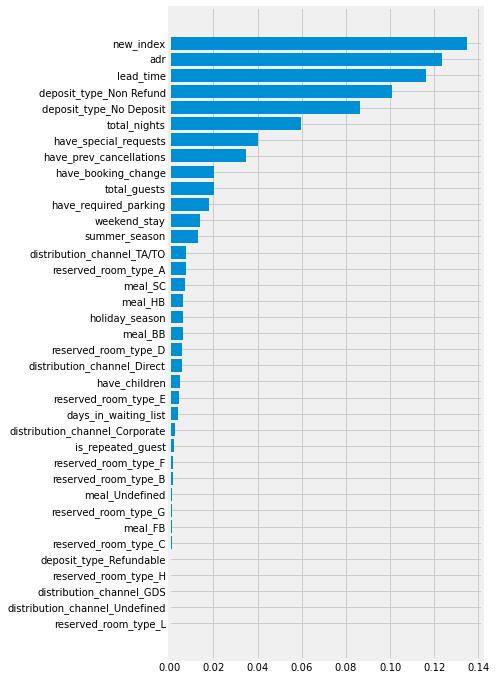

In [45]:
# Plotting the calculated feature importances by RF model

importance_df = pd.DataFrame(data=zip(X_train.columns, rf.feature_importances_))
importance_df.sort_values(by=[1], inplace=True)
plt.figure(figsize=(5, 12))
plt.barh(importance_df[0], importance_df[1])

In [46]:
importance_df.to_csv('importance_df.csv')

### The five most important features relate to deposit type, average daily value and lead time for the reservation. 

### Now the confusion matrix for the RF model:

In [47]:
# Devising the confusion matrix

def make_confusion_matrix(model, threshold=0.5):
    # Predict class 1 if probability of being in class 1 is greater than threshold
    # (model.predict(X_test) does this automatically with a threshold of 0.5)
    y_val_predict = (model.predict_proba(val_set_scaled)[:, 1] >= threshold)
    RF_confusion = confusion_matrix(y_val, y_val_predict)
    plt.figure(dpi=150)
    sns.heatmap(RF_confusion, cmap=plt.cm.Blues, annot=True, square=True)
    plt.xlabel('Predicted Cancellation')
    plt.ylabel('Actual Cancellation')
    plt.title('Random Forest Confusion Matrix')

In [48]:
from ipywidgets import interactive, FloatSlider

interactive(lambda threshold: make_confusion_matrix(rf, threshold), threshold=(0.0,1.0,0.01))

interactive(children=(FloatSlider(value=0.5, description='threshold', max=1.0, step=0.01), Output()), _dom_cla…

### By playing with the matrix, the optimal threshold to maximize F1 score seems to be around 0.35. In order to find the precise optimal threshold, Precision-Recall curve will be used: 

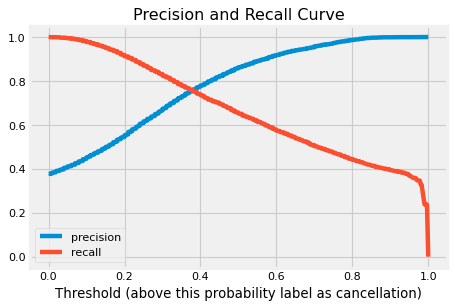

In [49]:
# Precision-Recall curve for RF model

precision_curve, recall_curve, threshold_curve = precision_recall_curve(y_val, rf.predict_proba(val_set_scaled)[:,1])

plt.figure(dpi=80)
plt.plot(threshold_curve, precision_curve[1:],label='precision')
plt.plot(threshold_curve, recall_curve[1:], label='recall')
plt.legend(loc='lower left')
plt.xlabel('Threshold (above this probability label as cancellation)');
plt.title('Precision and Recall Curve')

plt.savefig("P&R.png", bbox_inches='tight', dpi=600)

In [50]:
# Finding the optimal threshold from the Precision-Recall curve data

differences = abs(recall_curve - precision_curve)
np.where(differences==min(differences))
threshold_curve[np.where(differences==min(differences))]

array([0.38])

### And now the optimal threshold will be used to update the RF model:

In [51]:
y_val_predict = (rf.predict_proba(val_set_scaled)[:,1] > 0.377)


print(f'Random Forest Accuracy: {accuracy_score(y_val, y_val_predict):.3f}')
print(f'Random Forest Precision: {precision_score(y_val, y_val_predict):.3f}')
print(f'Random Forest Recall: {recall_score(y_val, y_val_predict):.3f}')
print(f'Random Forest F1: {f1_score(y_val, y_val_predict):.3f}')

Random Forest Accuracy: 0.817
Random Forest Precision: 0.753
Random Forest Recall: 0.760
Random Forest F1: 0.756


### With this new threshold, precision and recall have the same score

### One last issue should be addressed before finalizing the model. No hyper parameters were set for the initial RF model. One hyperparameter that can be the source of overfitting in a RF model is the max_depth. Possible effect of a high max_depth on model overfitting will be examined below: 

In [52]:
# Plot function

def max_depth_examiner():
    max_depths = np.linspace(1, 50, 50, endpoint=True)
    train_results = []
    val_results = []
    for max_depth in max_depths:
        rf = RandomForestClassifier(max_depth=max_depth)
        rf.fit(train_set_scaled, y_train)
        train_results.append(roc_auc_score(y_train, rf.predict_proba(train_set_scaled)[:,1]))
        val_results.append(roc_auc_score(y_val, rf.predict_proba(val_set_scaled)[:,1]))
    from matplotlib.legend_handler import HandlerLine2D
    line1, = plt.plot(max_depths, train_results, 'b', label='Train AUC')
    line2, = plt.plot(max_depths, val_results, 'r', label='Val AUC')
    plt.legend(handler_map={line1: HandlerLine2D(numpoints=2)})
    plt.ylabel('AUC Score')
    plt.xlabel('Tree Depth')
    plt.show()

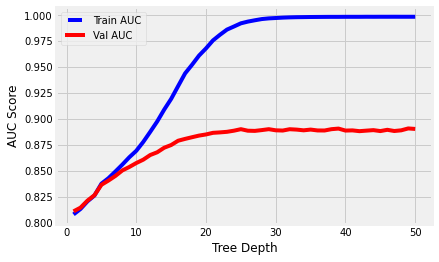

In [53]:
max_depth_examiner()

### Although a gap can be seen in the AUC score for train and validation sets for depths more than 10, but this gap remains constant. Increasing the max_depth would increase the model performance on both train and validation sets. In order to further examine this, the AUC average for CV groups will also be plotted for increasing max_depths:

In [54]:
# Plot function

def max_depth_examiner_cv():
    max_depths = np.linspace(1, 50, 50, endpoint=True)
    train_results = []
    val_results = []
    for max_depth in max_depths:
        rf = RandomForestClassifier(max_depth=max_depth)
        rf.fit(train_set_scaled, y_train)
        rf_train_scores = cross_validate(rf, train_set_scaled, y_train, cv=kf, scoring=['roc_auc'])
        train_results.append(np.mean(rf_train_scores['test_roc_auc']))
        val_results.append(roc_auc_score(y_val, rf.predict_proba(val_set_scaled)[:,1]))
    from matplotlib.legend_handler import HandlerLine2D
    line1, = plt.plot(max_depths, train_results, 'b', label='Train AUC')
    line2, = plt.plot(max_depths, val_results, 'r', label='Val AUC')
    plt.legend(handler_map={line1: HandlerLine2D(numpoints=2)})
    plt.ylabel('AUC Score')
    plt.xlabel('Tree Depth')
    plt.show()

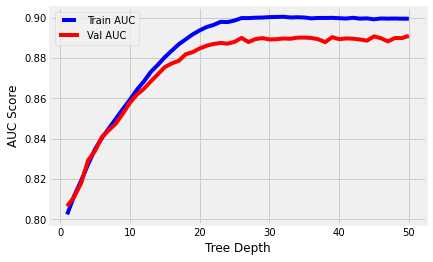

In [55]:
max_depth_examiner_cv()

### By plotting the cross validation average scores with the single validation scores, even the gap has almost vanished. Based on these results, no tuning will be done on the max_depth of the RF model.

### Now we update our model with the new threshold:

In [56]:
# Final RF model with adjusted threshold

def Final_Model(y, X, y_test, X_test, threshold=0.377):

    rf = RandomForestClassifier()
    rf.fit(X, y) 
    
    print(f'Random Forest Accuracy: {accuracy_score(y_test, (rf.predict_proba(X_test)[:,1] > threshold)):.3f}')
    print(f'Random Forest Precision: {precision_score(y_test, (rf.predict_proba(X_test)[:,1] > threshold)):.3f}')
    print(f'Random Forest Recall: {recall_score(y_test, (rf.predict_proba(X_test)[:,1] > threshold)):.3f}')
    print(f'Random Forest F1: {f1_score(y_test, (rf.predict_proba(X_test)[:,1] > threshold)):.3f}')
    print(f'Random Forest ROC_AUC: {roc_auc_score(y_test, rf.predict_proba(X_test)[:,1]):.3f}') 

In [57]:
# Scaling the train+validation and test sets for final assessment 

scaler = MinMaxScaler()
scaled_X = scaler.fit_transform(X)
X_scaled = X.copy()
X_scaled[['lead_time', 'is_repeated_guest', 'days_in_waiting_list', 'adr',
       'holiday_season', 'summer_season', 'total_nights', 'new',
       'weekend_stay', 'total_guests', 'have_children',
       'have_prev_cancellations', 'have_booking_change',
       'have_required_parking', 'have_special_requests', 'meal_BB', 'meal_FB',
       'meal_HB', 'meal_SC', 'meal_Undefined',
       'distribution_channel_Corporate', 'distribution_channel_Direct',
       'distribution_channel_GDS', 'distribution_channel_TA/TO',
       'distribution_channel_Undefined', 'reserved_room_type_A',
       'reserved_room_type_B', 'reserved_room_type_C', 'reserved_room_type_D',
       'reserved_room_type_E', 'reserved_room_type_F', 'reserved_room_type_G',
       'reserved_room_type_H', 'reserved_room_type_L',
       'deposit_type_No Deposit', 'deposit_type_Non Refund',
       'deposit_type_Refundable']] = scaled_X


scaled_test_X = scaler.fit_transform(X_test)
X_test_scaled = X_test.copy()
X_test_scaled[['lead_time', 'is_repeated_guest', 'days_in_waiting_list', 'adr',
       'holiday_season', 'summer_season', 'total_nights', 'new',
       'weekend_stay', 'total_guests', 'have_children',
       'have_prev_cancellations', 'have_booking_change',
       'have_required_parking', 'have_special_requests', 'meal_BB', 'meal_FB',
       'meal_HB', 'meal_SC', 'meal_Undefined',
       'distribution_channel_Corporate', 'distribution_channel_Direct',
       'distribution_channel_GDS', 'distribution_channel_TA/TO',
       'distribution_channel_Undefined', 'reserved_room_type_A',
       'reserved_room_type_B', 'reserved_room_type_C', 'reserved_room_type_D',
       'reserved_room_type_E', 'reserved_room_type_F', 'reserved_room_type_G',
       'reserved_room_type_H', 'reserved_room_type_L',
       'deposit_type_No Deposit', 'deposit_type_Non Refund',
       'deposit_type_Refundable']] = scaled_test_X

### And now we fit the final model on the combination of the train and validation sets and score it on the test (hold-out) set:

In [58]:
Final_Model(y, X_scaled, y_test, X_test_scaled, threshold=0.377)

Random Forest Accuracy: 0.822
Random Forest Precision: 0.754
Random Forest Recall: 0.787
Random Forest F1: 0.770
Random Forest ROC_AUC: 0.900
